In [2]:
import itertools
from tqdm.auto import tqdm
import random

from datasets import load_dataset
from pyvene import CausalModel

#### Special variables

In [3]:
# Longest command is 9 words : https://arxiv.org/pdf/1711.00350
max_command_len = 9
# dummy tokens for formatting
EMPTY = "<empty>" # "EMPTY"
PORT = "<port>"

#### Causal Model

In [4]:
# command type maps
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK",
    "turn": EMPTY,
    EMPTY: EMPTY,
    }

turns = {
    "around": "yyyy",
    "opposite": "yy",
    EMPTY: EMPTY
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT",
    EMPTY: EMPTY
}

nums = {
    "twice": "xx",
    "thrice": "xxx",
    EMPTY: EMPTY
}

conjs = ["and", "after", EMPTY]

# command structure
command_structure = {
    0: actions,
    1: turns,
    2: directions,
    3: nums,
    4: conjs,
    5: actions,
    6: turns,
    7: directions,
    8: nums,
}


### VARIABLES ###

# longest command is 9 words : https://arxiv.org/pdf/1711.00350
# This ordering (left to right) is important for downstream code!
leaves = [
    "act1", "trn1", "dir1", "num1",
    "conj",
    "act2", "trn2", "dir2", "num2"
]
non_leaves = [
    "trn1_res", "trn1_dir1", "act1_trn1_dir1", 
    "num1_res", "act1_trn1_dir1_num1",
    "trn2_res", "trn2_dir2", "act2_trn2_dir2", 
    "num2_res", "act2_trn2_dir2_num2",
    "conj_left", "conj_right",
]
variables = leaves + non_leaves

### FUNCTIONS ###

def resolve_turn(turn):
    return turns[turn]

# need to represent 'act' differently?
def turn_function(turn, dir):
    dir = directions[dir]
    if dir == EMPTY:
        return EMPTY
    elif turn == EMPTY:
        dec_act = dir + ' act '
    elif turn == "yyyy":
        dec_act = (dir + ' act ')*len(turn) 
    else:
        dec_act = (dir + ' ')*len(turn) + 'act'
    return dec_act.strip()

def action_function(act, trn_dir):
    if trn_dir == EMPTY:
        return actions[act]
    return trn_dir.replace('act', actions[act]).strip()

def resolve_num(num):
    return nums[num]

def num_function(act_trn_dir, num):
    if num == EMPTY:
        return act_trn_dir
    dec = (act_trn_dir + ' ') * len(num)
    return dec.strip()

def conjugation_left(act1_trn1_dir1_num1, conj):
    if conj == EMPTY:
        return act1_trn1_dir1_num1
    elif conj == "and":
        return act1_trn1_dir1_num1 + PORT
    else:
        return PORT + act1_trn1_dir1_num1
    

def conjugation_right(conj_left, act2_trn2_dir2_num2):
    if act2_trn2_dir2_num2 == EMPTY:
        f_str = conj_left
    # after
    elif conj_left.startswith(PORT):
        f_str = act2_trn2_dir2_num2 + conj_left
    # and
    else:
        f_str = conj_left + act2_trn2_dir2_num2
    f_str = f_str.replace(PORT, ' ')
    f_str = f_str.replace((' '+EMPTY+' '), ' ')
    f_str = f_str.replace(EMPTY, '')
    return f_str.strip()

functions = {

    # leaves
    "act1": lambda x: x,
    "act2": lambda x: x,
    "trn1": lambda x: x,
    "trn2": lambda x: x,
    "dir1": lambda x: x,
    "dir2": lambda x: x,
    "num1": lambda x: x,
    "num2": lambda x: x,
    "conj": lambda x: x,

    # resolving turn
    "trn1_res": resolve_turn,
    "trn2_res": resolve_turn,

    # combining turn and direction
    "trn1_dir1": turn_function,
    "trn2_dir2": turn_function,

    # combining turn_direction and action
    "act1_trn1_dir1": action_function,
    "act2_trn2_dir2": action_function,

    # resolving num
    "num1_res": resolve_num,
    "num2_res": resolve_num,

    # combining action_turn_direction and num
    "act1_trn1_dir1_num1": num_function,
    "act2_trn2_dir2_num2": num_function,

    # conj with left segment
    "conj_left": conjugation_left,

    # conj with right segment
    "conj_right": conjugation_right,
}


### VALUES ###

values = dict()

# leaves
values["act1"] = list(actions.keys())
values["act2"] = list(actions.keys())
values["trn1"] = list(turns.keys())
values["trn2"] = list(turns.keys())
values["dir1"] = list(directions.keys())
values["dir2"] = list(directions.keys())
values["num1"] = list(nums.keys())
values["num2"] = list(nums.keys())
values["conj"] = conjs


# resolve turn
values["trn1_res"] = [resolve_turn(t) for t in values["trn1"]]
values["trn2_res"] = values["trn1_res"].copy()

# turn+dir
all_trn_dir = list(itertools.product(values["trn1_res"], values["dir1"]))
values["trn1_dir1"] = list(set([turn_function(tup[0], tup[1]) for tup in all_trn_dir]))
values["trn2_dir2"] = values["trn1_dir1"].copy()

# act+turn_dir
all_act_trn_dir = list(itertools.product(values["act1"], values["trn1_dir1"]))
values["act1_trn1_dir1"] = list(set([action_function(tup[0], tup[1]) for tup in all_act_trn_dir]))
values["act2_trn2_dir2"] = values["act1_trn1_dir1"].copy()

# resolve num
values["num1_res"] = [resolve_num(n) for n in values["num1"]]
values["num2_res"] = values["num1_res"].copy()

# act_turn_dir+num
all_act_trn_dir_num = list(itertools.product(values["act1_trn1_dir1"], values["num1_res"]))
values["act1_trn1_dir1_num1"] = list(set([num_function(tup[0], tup[1]) for tup in all_act_trn_dir_num]))
values["act2_trn2_dir2_num2"] = values["act1_trn1_dir1_num1"].copy()

# conj_left
all_conj_left = list(itertools.product(values["act1_trn1_dir1_num1"], conjs))
values["conj_left"] = list(set([conjugation_left(tup[0], tup[1]) for tup in all_conj_left]))

# conj_right
all_conj_right = list(itertools.product(values["conj_left"], values["act2_trn2_dir2_num2"]))
values["conj_right"] = list(set([conjugation_right(tup[0], tup[1]) for tup in all_conj_right]))


### PARENTS ###

parents = {v:[] for v in variables}
# left subtree
parents["trn1_res"] = ["trn1"]
parents["trn1_dir1"] = ["trn1_res", "dir1"]
parents["act1_trn1_dir1"] = ["act1", "trn1_dir1"]
parents["num1_res"] = ["num1"]
parents["act1_trn1_dir1_num1"] = ["act1_trn1_dir1", "num1_res"]
# right subtree
parents["trn2_res"] = ["trn2"]
parents["trn2_dir2"] = ["trn2_res", "dir2"]
parents["act2_trn2_dir2"] = ["act2", "trn2_dir2"]
parents["num2_res"] = ["num2"]
parents["act2_trn2_dir2_num2"] = ["act2_trn2_dir2", "num2_res"]
# merge
parents["conj_left"] = ["act1_trn1_dir1_num1", "conj"]
parents["conj_right"] = ["conj_left", "act2_trn2_dir2_num2"]


### POSITIONS ###

# a dictionary with nodes as keys and positions as values
pos = {

    # left subtree
    "act1": (1, 0),
    "trn1": (2, 0),
    "dir1": (1.9, 0.05),
    "num1": (4, 0),
    "conj": (4.11, 0.1),
    "act1": (0.2, 0),
    "trn1": (1, 0.1),
    "trn1_res": (1.33, 0.4),
    "dir1": (2, 0.3),
    "num1": (2.8, 0),
    "num1_res": (3, 0.2),
    "trn1_dir1": (1.4, 0.96),
    "act1_trn1_dir1": (0.2, 1.5),
    "act1_trn1_dir1_num1": (2.5, 1.8),

    # right subtree
    "act2": (5, 0),
    "trn2": (6, 0),
    "dir2": (5.9, 0.05),
    "num2": (9, 0),
    "act2": (5.2, 0),
    "trn2": (6, 0.1),
    "trn2_res": (6, 0.4),
    "dir2": (7, 0.3),
    "num2": (9.8, 0),
    "num2_res": (9, 0.2),
    "trn2_dir2": (6.4, 1),
    "act2_trn2_dir2": (5.2, 1.5),
    "act2_trn2_dir2_num2": (7.5, 1.8),

    # merge
    "conj_left": (3.5, 2.2),
    "conj_right": (4.5, 3.2),
}

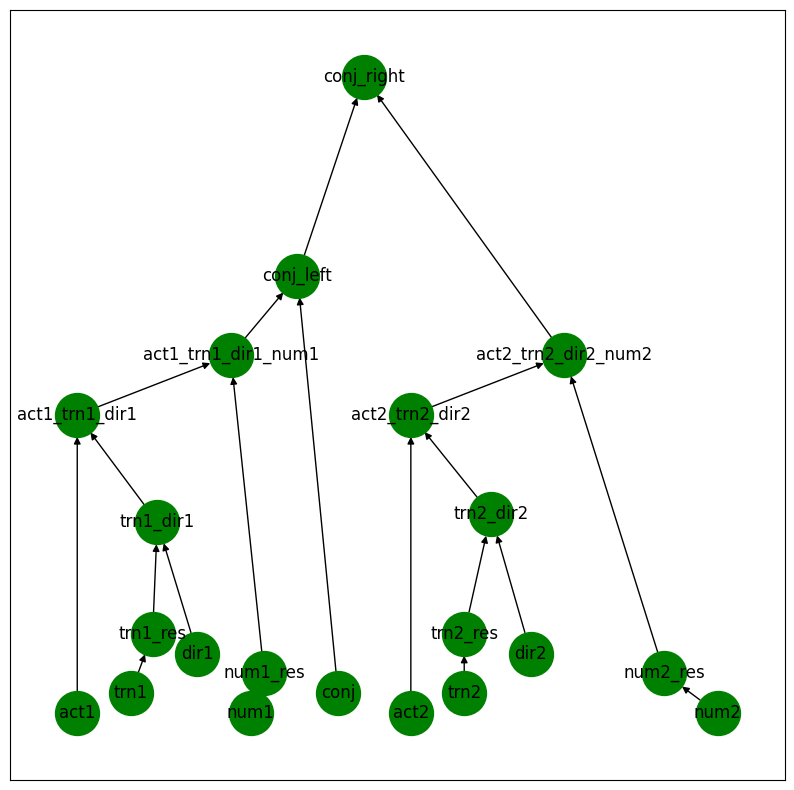

In [5]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()

#### Load dataset

In [6]:
# dataset splits
scan_simple = load_dataset('scan', 'simple', trust_remote_code=True)

# train and test splits
simple_train = scan_simple['train']
simple_test = scan_simple['test']

# cols
column_names = simple_train.column_names
input_column = column_names[0]
output_column = column_names[1]

## <sep> token? ##
# padded splits
def add_empty_token(x):
    command_str = x[input_column]
    command = command_str.split()
    padded_command = []
    index = 0
    c = 0
    while index < max_command_len:
        expected_cs = command_structure[index]
        if c < len(command) and command[c] in expected_cs:
            padded_command.append(command[c])
            c += 1
        else:
            padded_command.append(EMPTY)
        index += 1
    
    x[input_column] = ' '.join(padded_command)
    return x

simple_train_padded = simple_train.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)
simple_test_padded = simple_test.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)

#### Causal model with no intervention

base : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
No intervention:
 defaultdict(None, {'act1': 'run', 'act2': 'walk', 'conj': 'after', 'dir1': 'left', 'dir2': 'right', 'num1': '<empty>', 'num2': '<empty>', 'trn1': 'opposite', 'trn2': '<empty>', 'num1_res': '<empty>', 'num2_res': '<empty>', 'trn1_res': 'yy', 'trn2_res': '<empty>', 'trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT act', 'trn2_dir2': 'I_TURN_RIGHT act', 'act1_trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2': 'I_TURN_RIGHT I_WALK', 'act1_trn1_dir1_num1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2_num2': 'I_TURN_RIGHT I_WALK', 'conj_left': '<port>I_TURN_LEFT I_TURN_LEFT I_RUN', 'conj_right': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}) 



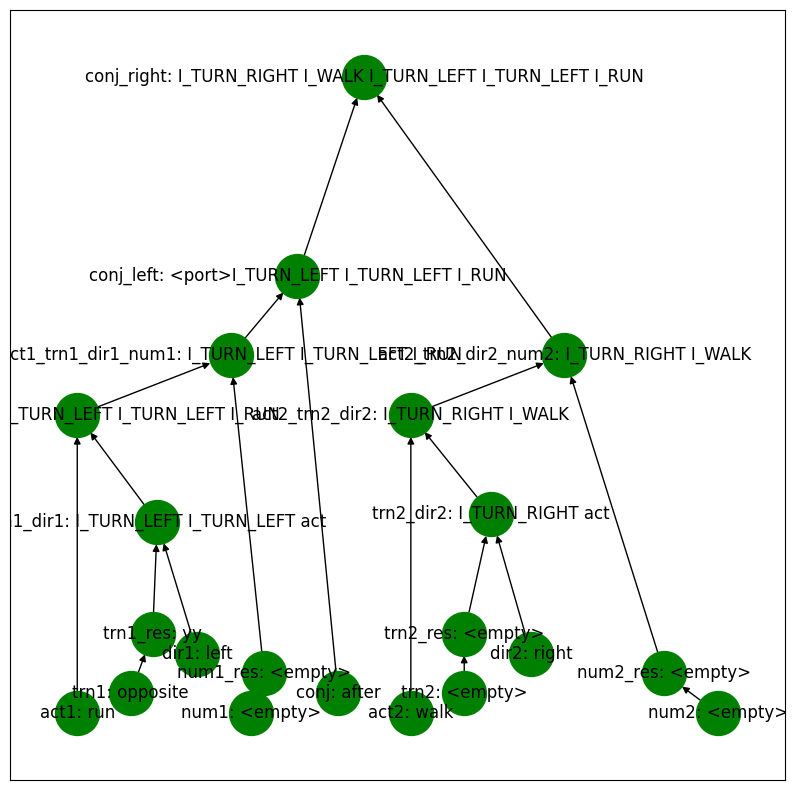

In [7]:
example = simple_train_padded[1]
print('base : {}'.format(example))

padded_command = example[input_column].split()
# assume leaves are correctly ordered from left to right
causal_model_inputs = {leaves[i]:padded_command[i] for i in range(max_command_len)}
base_setting = causal_model.run_forward(causal_model_inputs)
print("No intervention:\n", base_setting, "\n")
causal_model.print_setting(base_setting)

#### Causal model with an intervention

Intervention setting trn2_dir2 to left turn:



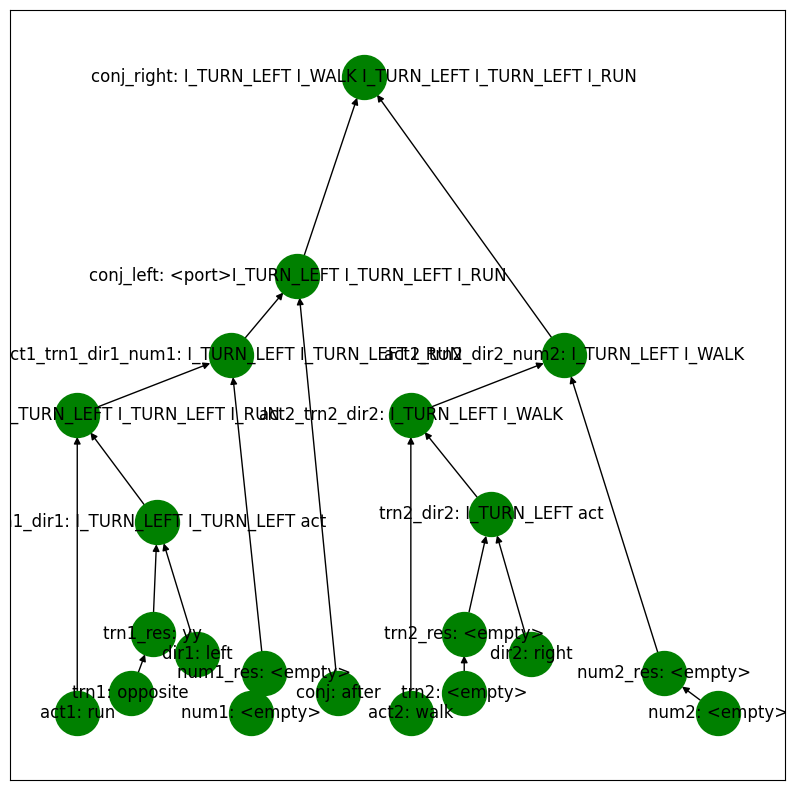

In [8]:
print("Intervention setting trn2_dir2 to left turn:\n",)
## how to do this intervention for gpt? ##
causal_model_inputs['trn2_dir2'] = directions['left'] + ' act'

causal_model.print_setting(causal_model.run_forward(causal_model_inputs))

#### Interchange intervention

base example : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
source example : {'commands': 'walk <empty> <empty> <empty> after run around right twice', 'actions': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_WALK'}


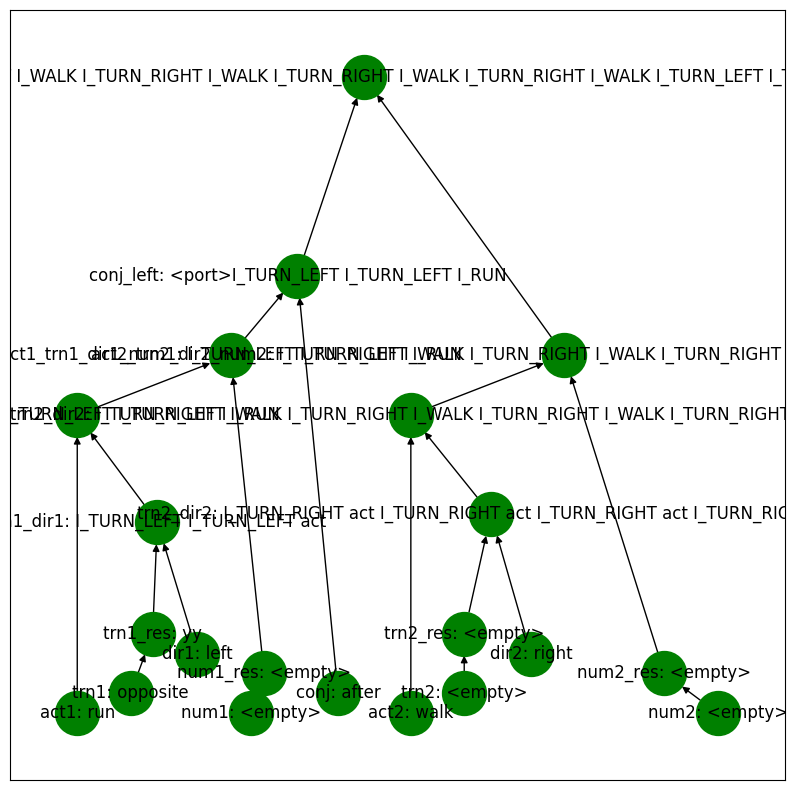

In [9]:
example = simple_train_padded[1]
print('base example : {}'.format(example))
padded_command = example[input_column].split()
base = {leaves[i]:padded_command[i] for i in range(max_command_len)}

source_example = simple_train_padded[2]
print('source example : {}'.format(source_example))
padded_command = source_example[input_column].split()
source = {leaves[i]:padded_command[i] for i in range(max_command_len)}
setting = causal_model.run_interchange(base, {"trn2_dir2": source})
causal_model.print_setting(setting)

In [10]:
print(base_setting['trn2_dir2'])
print(setting['trn2_dir2'])

I_TURN_RIGHT act
I_TURN_RIGHT act I_TURN_RIGHT act I_TURN_RIGHT act I_TURN_RIGHT act


#### Intervention on conj_left

##### Build factual SCAN dataset

Make sure every sample has a conj. Sample each leaf and make sure it's a valid leaf value configuration for the input.

In [23]:
def validate_leaf_config(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True


def input_sampler():
    invalid_input = True
    while invalid_input:
        input = {}
        for posn, val in command_structure.items():
            if isinstance(val, dict):
                command_type_keys = list(val.keys())
            elif isinstance(val, list):
                command_type_keys = val
            else:
                raise ValueError("Invalid command type. Check command type maps")
            r_key = random.choice(command_type_keys)
            # assuming leaves is a list with ordered values
            input[leaves[posn]] = r_key
        invalid_input = validate_leaf_config(input)
    return input

#input_sampler()


{'act1': 'jump',
 'trn1': 'around',
 'dir1': 'right',
 'num1': 'twice',
 'conj': 'and',
 'act2': 'turn',
 'trn2': '<empty>',
 'dir2': '<empty>',
 'num2': 'thrice'}

In [ ]:
n_examples = 1048576
batch_size = 1024

#size,
#sampler=None,
#filter=None,
#device="cpu",
#input_function=None, -> ?
#output_function=None, -> ?
#return_tensors=True,
examples = causal_model.generate_factual_dataset(n_examples, input_sampler)

#X = torch.stack([example['input_ids'] for example in examples])
#y = torch.stack([example['labels'] for example in examples])